<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/master/Data%20Augmentation/GradCamAndCutout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this notebook, let us explore how to use
## [Grad-Cam](https://www.hackevolve.com/where-cnn-is-looking-grad-cam/) and [CutOut](https://github.com/yu4u/cutout-random-erasing)



### Importing libraries 

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras.utils import np_utils

### Loading CIFAR10 dataset 

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

**Visualize some sample Images from the dataset**

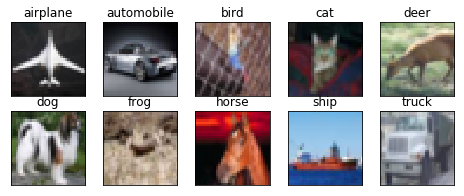

In [12]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

**Defining functions to plot model history, find accuracy**

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def accuracy_iterator(test_iterator, model):
  _, accuracy = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
  return (accuracy * 100)

### Define Model and standardize the inputs

**Dividing pixel values by 255, standardize the inputs, also performed one hot encoding**

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [17]:
# Define the model
model = Sequential()
model.add(Convolution2D(128, (3, 3), padding='same', input_shape=(32, 32, 3), use_bias=False)) #30
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(256, (3, 3), padding='same', use_bias=False)) #28 
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(64, (1, 1), activation='relu', use_bias=False)) #28
model.add(MaxPooling2D(pool_size=(2, 2)))#14

model.add(Convolution2D(128, (3, 3), padding='same', use_bias=False)) #12
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(256, (3, 3), padding='same', use_bias=False)) #10
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(64, (1, 1), activation='relu', use_bias=False)) #10
model.add(MaxPooling2D(pool_size=(2, 2)))#5

model.add(Convolution2D(128, (3, 3), padding='same', use_bias=False)) #3
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))


model.add(Convolution2D(256, (3, 3), padding='same', use_bias=False)) #1
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Convolution2D(10, 8, 8, use_bias=False))
model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (8, 8), use_bias=False)`


In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 128)       3456      
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 256)       294912    
_________________________________________________________________
batch_normalization_12 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 256)      

In [0]:
# checkpoint
filepath="/content/drive/My Drive/AdvancedConvolutions/GradCam/Models/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')

In [0]:
callbacks_list = [earlystop, checkpoint]

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
391/391 [==============================] - 94s 241ms/step - loss: 2.0809 - acc: 0.3843 - val_loss: 2.6397 - val_acc: 0.3525

Epoch 00001: val_acc improved from -inf to 0.35250, saving model to /content/drive/My Drive/AdvancedConvolutions/GradCam/Models/weights-01-0.35.hdf5
Epoch 2/100
391/391 [==============================] - 87s 222ms/step - loss: 1.5275 - acc: 0.5388 - val_loss: 1.2774 - val_acc: 0.5356

Epoch 00002: val_acc improved from 0.35250 to 0.53560, saving model to /content/drive/My Drive/AdvancedConvolutions/GradCam/Models/weights-02-0.54.hdf5
Epoch 3/100
391/391 [==============================] - 87s 222ms/step - loss: 1.1788 - acc: 0.6153 - val_loss: 1.0625 - val_acc: 0.6212

Epoch 00003: val_acc improved from 0.53560 to 0.62120, saving model to /content/drive/My Drive/AdvancedConvolutions/GradCam/Models/weights-03-0.62.hdf5
Epoch 4/100
391/391 [=====================

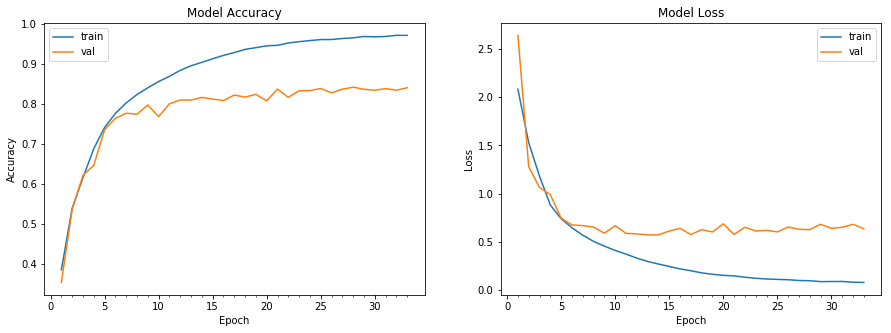

Accuracy on test data is: 84.08


In [23]:
from keras.preprocessing.image import ImageDataGenerator

# applying transformation to image
train_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit the data augmentation
train_gen.fit(train_features)
test_gen.fit(test_features)

training_generator= train_gen.flow(train_features, train_labels, batch_size=128)
testing_generator= test_gen.flow(test_features, test_labels, batch_size=128, shuffle=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(training_generator, 
                    steps_per_epoch = len(training_generator),
                    epochs=100,
                    validation_data = testing_generator,
                    validation_steps = len(testing_generator),
                    callbacks = callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy_iterator(testing_generator, model))

# GRAD-CAM

In [0]:
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import cv2
import sys

In [0]:
#img_path = sys.argv[1]
#img = image.load_img(img_path, target_size=(32, 32))
x = image.img_to_array(test_features[10])
x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)

In [0]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_23")

In [0]:
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(10):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

In [32]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


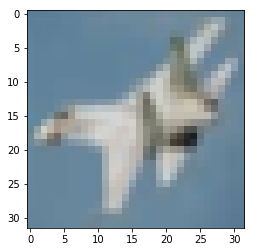

In [41]:
from google.colab.patches import cv2_imshow
img = test_features[10]
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0, dtype=cv2.CV_32F)
plt.imshow(img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


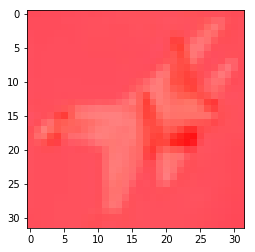

In [42]:
plt.imshow(superimposed_img)
#cv2.waitKey(0)

# With CutOuts

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
filepath="/content/drive/My Drive/AdvancedConvolutions/WithCutOut/Models/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# define early stopping callback
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
# define early stopping callback
callbacks_list = [earlystop, checkpoint]

Epoch 1/100
391/391 [==============================] - 88s 224ms/step - loss: 0.3067 - acc: 0.8962 - val_loss: 0.5136 - val_acc: 0.8384

Epoch 00001: val_acc improved from -inf to 0.83840, saving model to /content/drive/My Drive/AdvancedConvolutions/WithCutOut/Models/weights-01-0.84.hdf5
Epoch 2/100
391/391 [==============================] - 87s 223ms/step - loss: 0.2528 - acc: 0.9112 - val_loss: 0.5534 - val_acc: 0.8378

Epoch 00002: val_acc did not improve from 0.83840
Epoch 3/100
391/391 [==============================] - 87s 223ms/step - loss: 0.2335 - acc: 0.9179 - val_loss: 0.5460 - val_acc: 0.8452

Epoch 00003: val_acc improved from 0.83840 to 0.84520, saving model to /content/drive/My Drive/AdvancedConvolutions/WithCutOut/Models/weights-03-0.85.hdf5
Epoch 4/100
391/391 [==============================] - 87s 223ms/step - loss: 0.2143 - acc: 0.9259 - val_loss: 0.5222 - val_acc: 0.8450

Epoch 00004: val_acc did not improve from 0.84520
Epoch 5/100
391/391 [========================

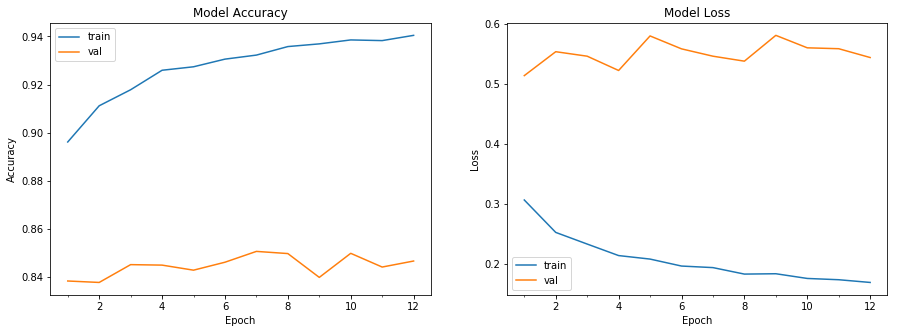

Accuracy on test data is: 84.67


In [51]:
from keras.preprocessing.image import ImageDataGenerator

# applying transformation to image
train_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))
test_gen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
# fit the data augmentation
train_gen.fit(train_features)
test_gen.fit(test_features)

training_generator= train_gen.flow(train_features, train_labels, batch_size=128)
testing_generator= test_gen.flow(test_features, test_labels, batch_size=128, shuffle=False)


# train the model
start = time.time()
# Train the model
cutout_model_info = model.fit_generator(training_generator, 
                    steps_per_epoch = len(training_generator),
                    epochs=100,
                    validation_data = testing_generator,
                    validation_steps = len(testing_generator),
                    callbacks = callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(cutout_model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy_iterator(testing_generator, model))

In [54]:
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]
last_conv_layer = model.get_layer("conv2d_23")
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(10):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

img = test_features[10]
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0, dtype=cv2.CV_32F)
plt.imshow(img)

AttributeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


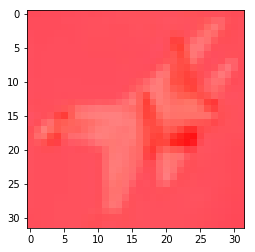

In [53]:
plt.imshow(superimposed_img)